## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from fasttext import load_model
import math



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import lightgbm as lgb


## Settings

In [2]:
DATA_PATH = "/home/knikaido/work/atma10/data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
SUB_PATH = DATA_PATH + "atmacup10__sample_submission.csv"

In [3]:
SEED = 42
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 1000,
    'verbose_eval': 200,
}

SAVE_TEST_SUB_PATH = "sub09.csv"
SAVE_OOF_SUB_PATH = "oof09.csv"

## Utility

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

In [5]:
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

## Feature Engineering

In [6]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
len_train = len(train)

saturation_train = pd.read_csv(DATA_PATH + 'saturation_train.csv')
train = train.merge(saturation_train, how='left', on='object_id')
saturation_test = pd.read_csv(DATA_PATH + 'saturation_test.csv')
test = test.merge(saturation_test, how='left', on='object_id')
y = np.log1p(train["likes"])
whole_df = pd.concat([train, test]).reset_index(drop=True)
train

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes,saturation
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48,239.0
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2,110.0
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5,NaN
3,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,bequest,1881-01-01T00:00:00,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100,229.0
4,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,unknown,1971-01-01T00:00:00,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,ffedf8af4fd5b3873164,2e4695e7f3260d52b3e6,De schilder H.W. Mesdag voor een doek,NaN,"De schilder H.W. Mesdag voor een doek, Delboy ...",Delboy & Baer,Delboy & Baer,h 90mm × w 140mm,NaN,De schilder H.W. Mesdag voor een doek H W Mesdag,transfer,1994-01-01T00:00:00,NaN,1900 - 1920,1900.0,19,1900.0,1920.0,4,61.0
12022,ffee34705ea44e1a0f79,7aa656a9ef243d93d009,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim, Speyer en...","Kaart van de streek tussen Mannheim en Landau,...",Abraham Allard,Abraham Allard,h 245mm × w 278mm,NaN,"Kaart van de streek tussen Mannheim en Landau,...",purchase,1881-01-01T00:00:00,NaN,1701 - 1714,1701.0,18,1701.0,1714.0,0,183.0
12023,ffefbe1faf771aa4f790,e79c2e74ed17533a7e56,Storm op het IJ aan het Blauwhoofd van Amsterd...,Zeilschepen in de problemen op het IJ ter hoog...,Storm op het IJ aan het Blauwhoofd van Amsterd...,Noach van der Meer (II),Noach van der Meer (II),h 217mm × w 306mm,NaN,Storm op het IJ aan het Blauwhoofd van Amsterd...,transfer,1887-01-01T00:00:00,NaN,1778,1778.0,18,1778.0,1778.0,0,95.0
12024,fff08e76cbb969eaddc7,510358b74c1104edbbbd,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689. Spotprent op de...","Het rad van fortuin, ca. 1689, Romeyn de Hoogh...",Romeyn de Hooghe,Romeyn de Hooghe,h 560mm × w 405mm,NaN,"Het rad van fortuin, ca. 1689 'T Hedendaags Ra...",purchase,1881-01-01T00:00:00,NaN,1689 - 1690,1689.0,17,1689.0,1690.0,14,139.0


In [7]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'saturation'
    ]
    output_df = input_df[use_columns].copy()
#     output_df['date_range'] = input_df['dating_year_late'] - input_df['dating_year_early']

    return output_df

In [8]:
def create_size_feature(input_df):
    
    output_df = pd.DataFrame()
    for i, axis in  enumerate(['h', 'w', 't', 'd', 'w']):
        if i <= 3:
            column_name = f'size_{axis}'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*\/\d*|\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
        else :
            column_name = 'weight'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*\/\d*|\d*|\d*\.\d*)(kg)'.format(axis)) # 正規表現を使ってサイズを抽出
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].str.replace('/', '.')
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
        output_df[column_name] = size_info[column_name] # trainにくっつける
    output_df['area'] = output_df['size_t'] * output_df['size_w']

    return output_df

In [9]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title'
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

In [10]:
def create_count_encoding_feature(input_df):
    ## 'principal_or_first_maker'は'principal_maker'と相関高いので削除
    use_columns = ['principal_maker', 
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late']

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = input_df[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

In [21]:
def create_language_feature(input_df):
    use_columns = ['title', 'description', 'more_title',
        'long_title', 'principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line']
    model = load_model(DATA_PATH + "lid.176.bin")
    
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df[column] = input_df[column].fillna("").map(
            lambda x: model.predict(x.replace("\n", ""))[0][0]).astype(str)
        le = LabelEncoder()
        out_df[column] = le.fit_transform(out_df[column])
        
    return out_df.add_prefix('lang_')

#     out_df = pd.DataFrame()
#     for column in use_columns:
#         lang_series = input_df[column].fillna("").map(
#             lambda x: model.predict(x.replace("\n", ""))[0][0]).astype(str)
        
#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = lang_series.value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(lang_series, categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

In [22]:
def create_label_encoding(input_df):
    ## 'principal_or_first_maker'は'principal_maker'と相関高いが，削除するとCV下がったので残す
    use_columns = ['principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late']
    
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df[column] = input_df[column].astype(str)
        le = LabelEncoder()
        out_df[column] = le.fit_transform(out_df[column])
        
    return out_df.add_prefix('LE_')

In [23]:
def create_one_hot_encoding(input_df):
    use_columns = [
        'dating_period',
#         'principal_maker'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:

        # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
        vc = input_df[column].value_counts()
        vc = vc[vc > 10]

        # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
        cat = pd.Categorical(input_df[column], categories=vc.index)

        # このタイミングで one-hot 化
        out_i = pd.get_dummies(cat)
        # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

In [24]:
def create_maker_info(input_df):
    
    tgt = 'principal_maker'
    col = 'dating_sorting_date'
    val = 'object_id'
    plat_pivot = input_df.pivot_table(index=tgt, columns=col, values=val, aggfunc='count').reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:8] +  '_' + col[-4:]+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    out_df = pd.merge(input_df, plat_pca_df, on=tgt, how='left')[cols]
            
    return out_df

In [25]:
def create_title_info(input_df):
    
    tgt = 'title'
    col = 'principal_maker'
    val = 'object_id'
    plat_pivot = input_df.pivot_table(index=tgt, columns=col, values=val, aggfunc='count').reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt +  '_' + col[-4:]+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    out_df = pd.merge(input_df, plat_pca_df, on=tgt, how='left')[cols]
            
    return out_df

In [26]:
def create_bert_description_info(input_df):
    
    bert_df = pd.read_csv(DATA_PATH + 'bert_description_info.csv')

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(bert_df.iloc[:, 1:].values) 
    cols = ['bert_descript_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca,  columns=cols)
            
    return plat_pca_df

In [27]:
def create_material_info(input_df):
    
    material_df = pd.read_csv(DATA_PATH + 'material_info.csv')
    out_df = pd.merge(input_df, material_df, on='object_id', how='left')
            
    return out_df[material_df.columns].drop('object_id', axis=1)

In [28]:
def create_place_info(input_df):
    
    production_country = pd.read_csv(DATA_PATH + 'production_place_country.csv')   
    out_df = pd.merge(input_df, production_country, on='object_id', how='left')
            
    return out_df[production_country.columns].drop('object_id', axis=1)

In [29]:
def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_numeric_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_label_encoding,
        create_size_feature,
        create_language_feature,
        create_maker_info,
        create_title_info,
        create_material_info,
        create_place_info,
        create_bert_description_info
#         create_one_hot_encoding
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='' + func.__name__ + ' '):
            _df = func(input_df)

        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [30]:
whole_feat_df = to_feature(whole_df)

 36%|███▋      | 4/11 [00:00<00:00, 34.24it/s]

create_numeric_feature  0.001[s]
create_string_length_feature  0.023[s]
create_count_encoding_feature  0.020[s]
create_label_encoding  0.066[s]
create_size_feature  1.197[s]


create_language_feature  2.186[s]
create_maker_info  0.273[s]


 91%|█████████ | 10/11 [00:07<00:00,  1.23it/s]

create_title_info  3.941[s]
create_material_info  0.029[s]
create_place_info  0.034[s]


100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

create_bert_description_info  3.016[s]


In [31]:
test_feat_df = whole_feat_df.iloc[len_train:].reset_index(drop=True)
train_feat_df = whole_feat_df.iloc[:len_train].reset_index(drop=True)
X = train_feat_df
X

,dating_period,dating_year_early,dating_year_late,saturation,StringLength__title,StringLength__long_title,StringLength__sub_title,StringLength__more_title,CE_principal_maker,CE_copyright_holder,...,bert_descript_pca_90,bert_descript_pca_91,bert_descript_pca_92,bert_descript_pca_93,bert_descript_pca_94,bert_descript_pca_95,bert_descript_pca_96,bert_descript_pca_97,bert_descript_pca_98,bert_descript_pca_99
0,17,1660.0,1685.0,239.0,21,48,39.0,21.0,5,NaN,...,0.000337,-0.000438,-0.000089,-0.000035,0.000055,0.000561,0.000131,-0.000008,-0.000393,0.000093
1,19,1900.0,1930.0,110.0,15,64,17.0,15.0,364,364.0,...,0.000337,-0.000438,-0.000089,-0.000035,0.000055,0.000561,0.000131,-0.000008,-0.000393,0.000093
2,19,1860.0,1880.0,NaN,21,52,15.0,21.0,1,NaN,...,0.058975,0.151470,0.052403,0.040743,-0.084309,0.029754,-0.005480,0.041034,0.259533,0.124047
3,19,1850.0,1879.0,229.0,16,53,25.0,16.0,1,NaN,...,-0.110774,-0.031948,-0.107044,0.103597,0.222801,-0.138865,-0.084081,-0.073290,0.006850,0.047396
4,19,1825.0,1874.0,255.0,27,51,27.0,27.0,3457,NaN,...,0.296058,0.097245,0.346181,0.358098,-0.181707,-0.201316,-0.050373,0.014032,0.092563,-0.172165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,19,1900.0,1920.0,61.0,37,65,16.0,48.0,3,NaN,...,0.000337,-0.000438,-0.000089,-0.000035,0.000055,0.000561,0.000131,-0.000008,-0.000393,0.000093
12022,18,1701.0,1714.0,183.0,60,89,17.0,424.0,42,NaN,...,-0.224928,-0.103573,-0.053489,-0.081537,-0.051540,-0.151087,0.045568,0.109755,-0.253164,-0.005447
12023,18,1778.0,1778.0,95.0,54,85,17.0,141.0,5,NaN,...,-0.055152,0.039827,0.069054,-0.040004,0.211858,-0.120221,0.172145,0.227504,0.033098,0.051834
12024,17,1689.0,1690.0,139.0,29,72,17.0,145.0,266,NaN,...,0.026780,-0.264980,-0.006343,0.032100,-0.305069,0.027694,0.018729,-0.071858,-0.242127,0.129331


In [32]:
def corr_column(df, threshold):

    df_corr = df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns

    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0

    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None

        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()

        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None

            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column

            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)

    return df_corr.columns

## Train / Test

In [33]:
def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))

In [34]:

kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)

y_test = np.zeros([N_SPLITS, len(test_feat_df)])
oof_pred = np.zeros_like(y, dtype=np.float)
models = []

# kfoldで分割
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    # 学習
    model = lgb.train(LGBM_PARAMS,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        **LGBM_FIT_PARAMS)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_valid, num_iteration=model.best_iteration)
    oof_pred[valid_index] = predict_eval
    models.append(model)
    
    rmse_train = calc_loss(y_train, predict_train)
    rmse_eval = calc_loss(y_valid, predict_eval)
    print(f'epoch: {i} RMSE_train: {rmse_train}, RMSE_eval: {rmse_eval}')
    
    y_test[i] = model.predict(test_feat_df, num_iteration=model.best_iteration)
    
oof_score = calc_loss(y, oof_pred)
print(f'RMSE_oof: {oof_score}')

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.750611	valid_0's rmse: 1.04119
[400]	training's rmse: 0.603308	valid_0's rmse: 1.03314
[600]	training's rmse: 0.515277	valid_0's rmse: 1.03235
[800]	training's rmse: 0.45454	valid_0's rmse: 1.03388
[1000]	training's rmse: 0.408613	valid_0's rmse: 1.03534
[1200]	training's rmse: 0.372549	valid_0's rmse: 1.0377
[1400]	training's rmse: 0.343204	valid_0's rmse: 1.03957
Early stopping, best iteration is:
[567]	training's rmse: 0.526978	valid_0's rmse: 1.03124
epoch: 0 RMSE_train: 0.5269778431412032, RMSE_eval: 1.0312401425973712
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.747457	valid_0's rmse: 1.05327
[400]	training's rmse: 0.600371	valid_0's rmse: 1.04784
[600]	training's rmse: 0.511	valid_0's rmse: 1.04711
[800]	training's rmse: 0.449934	valid_0's rmse: 1.04836
[1000]	training's rmse: 0.40323	valid_0's rmse: 1.05057
[1200]	training's rmse: 0.366404	valid_0's

In [35]:
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)
sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [36]:
oof_pred_ex = np.expm1(oof_pred)
oof_df = pd.DataFrame(oof_pred_ex)
oof_df.to_csv(SAVE_OOF_SUB_PATH,index=False)

In [37]:
1.0330156888922877

1.0354060686262923

## Confirm

<AxesSubplot:>

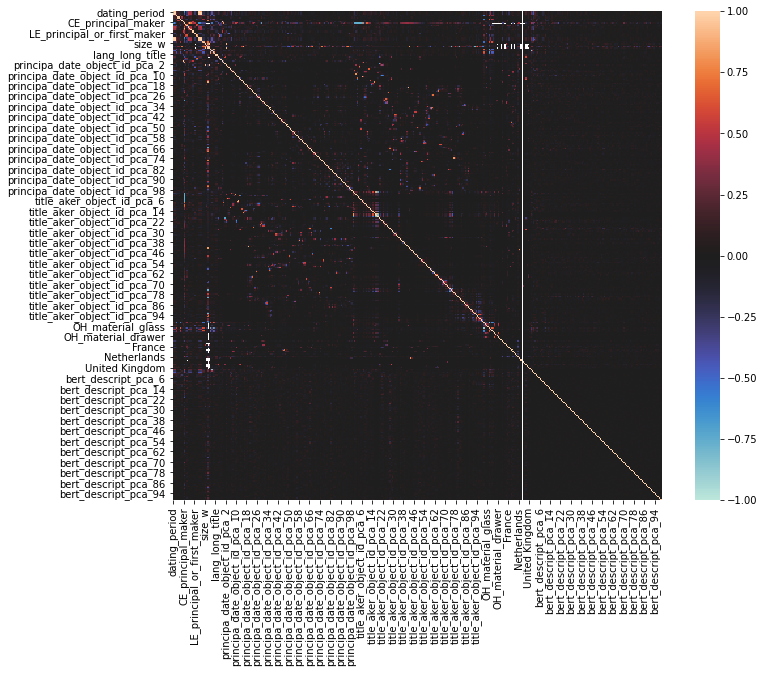

In [38]:
fig, ax = plt.subplots(figsize=(12, 9)) 
sns.heatmap(train_feat_df.corr(), square=True, vmax=1, vmin=-1, center=0)

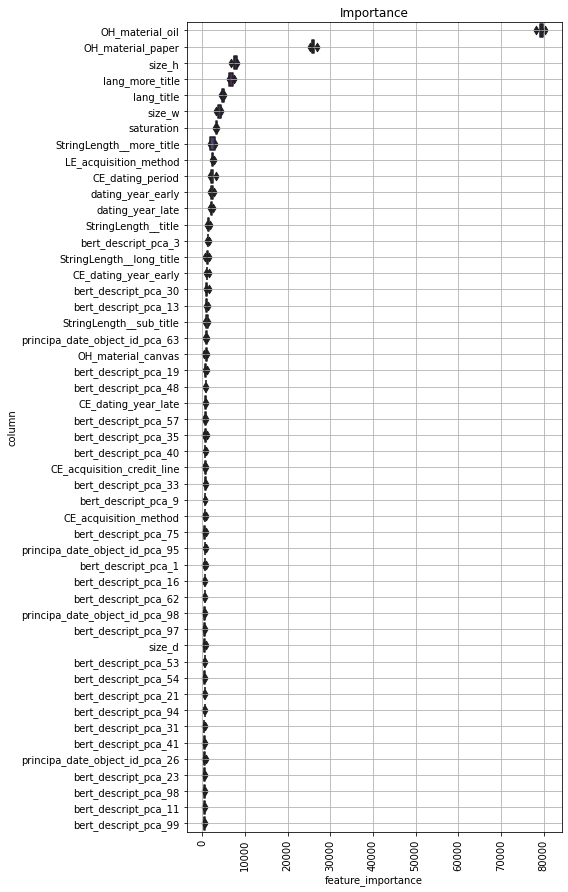

In [39]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

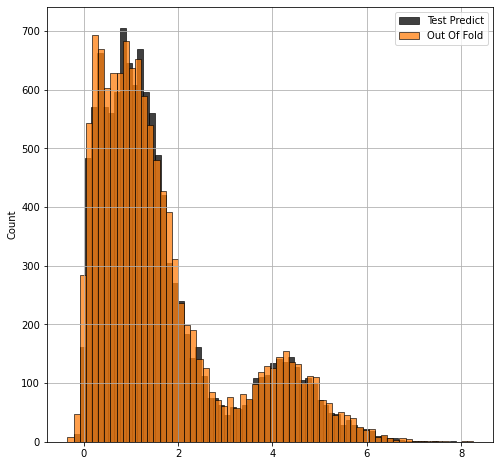

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(y_test_sub), label='Test Predict', ax=ax, color='black')
sns.histplot(oof_pred, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()